# Predicting Toronto Ferry Activity

In [1]:
from Model import RedemptionModel 
import pandas as pd 

/Users/marianomaisonnave/Repositories/COMP-44081/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features 
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [3]:
df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')
df.head()

,_id,Redemption Count,Sales Count,monthly,quarter
Timestamp,,,,,
2015-05-01,985694,1,4,5,2
2015-05-02,0,0,0,5,2
2015-05-03,0,0,0,5,2
2015-05-04,4681828,12,75,5,2
2015-05-05,11333457,537,549,5,2


23:13:17 - cmdstanpy - INFO - Chain [1] start processing
23:13:17 - cmdstanpy - INFO - Chain [1] done processing
23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:18 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:22 - cmdstanpy - INFO - Chain [1] done processing
23:13:22 - cmdstanpy - INFO - Chain [1] start processing
23:13:22 - cmdstanpy - INFO - Chain [1] done processing
23:13:26 - cmdstanpy - INFO - Chain [1] start processing
23:13:26 - cmdstanpy - INFO - Chain [1] done processing
23:13:27 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
/Users/marianomaisonnave/Repositories/COMP-44081/Model.py:259: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_w

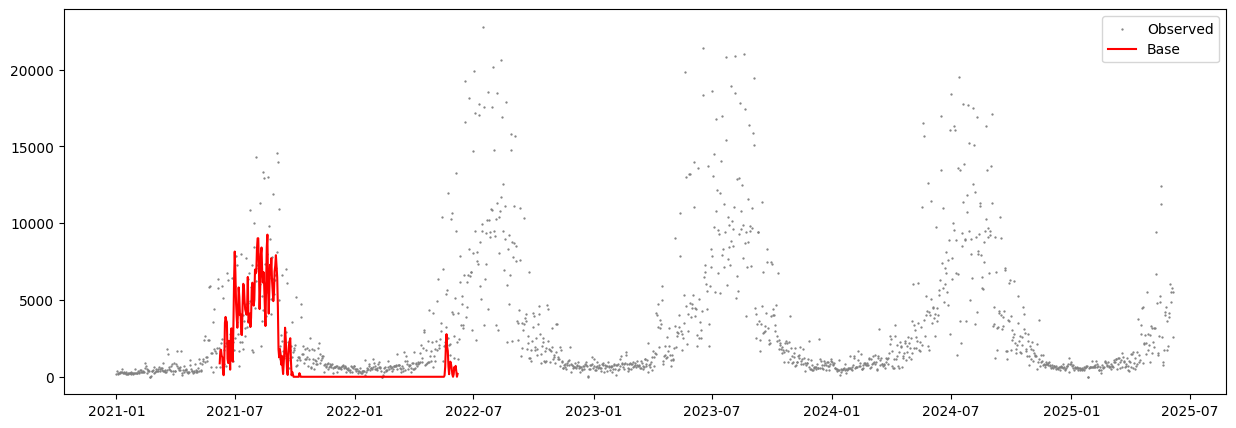

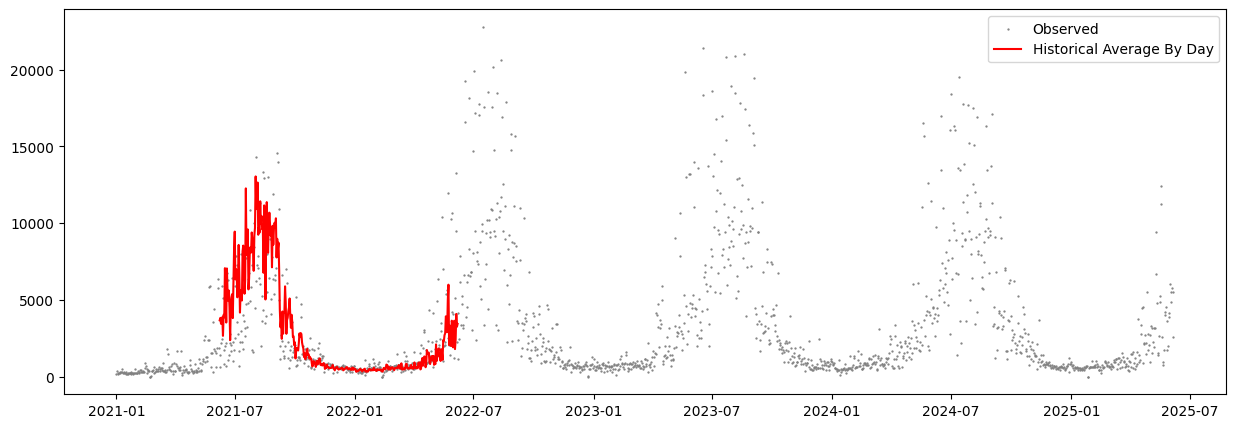

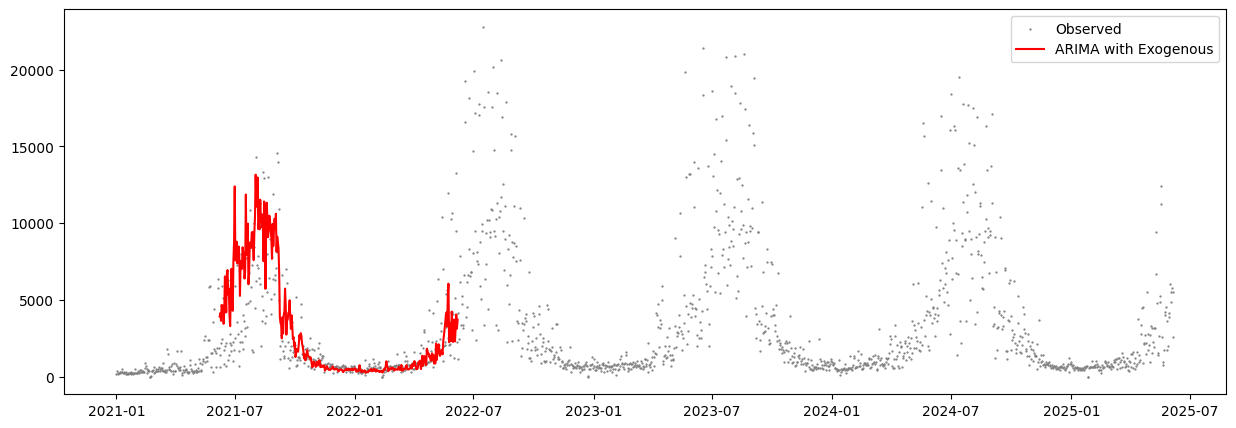

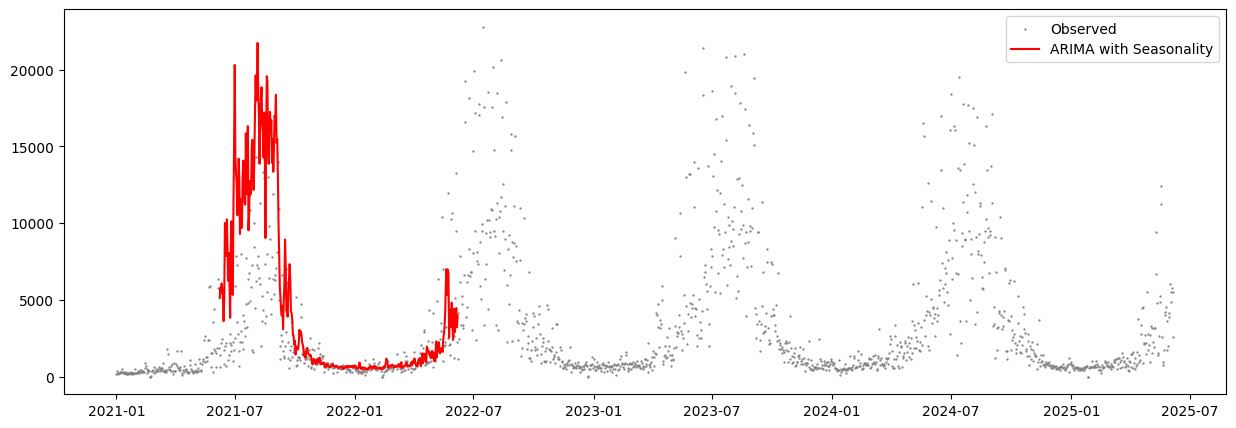

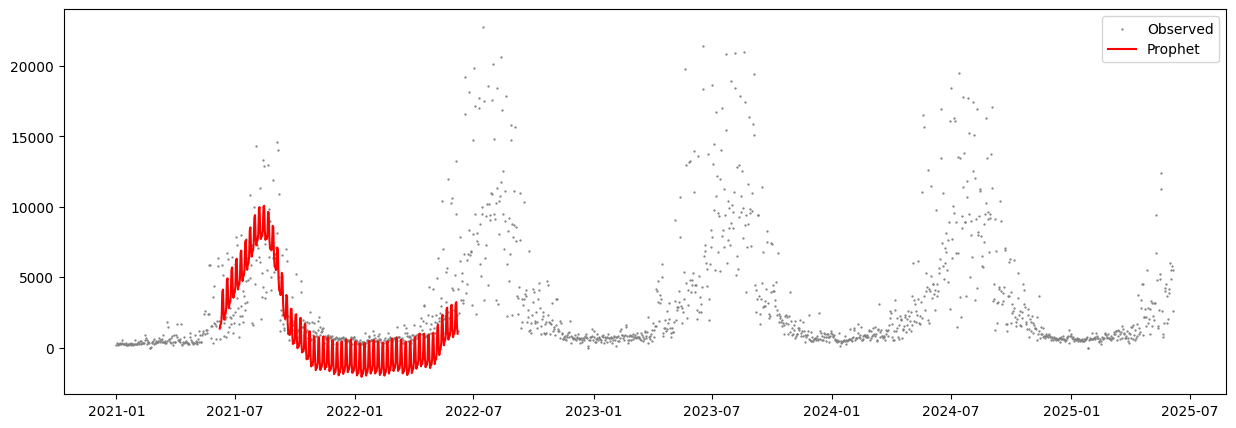

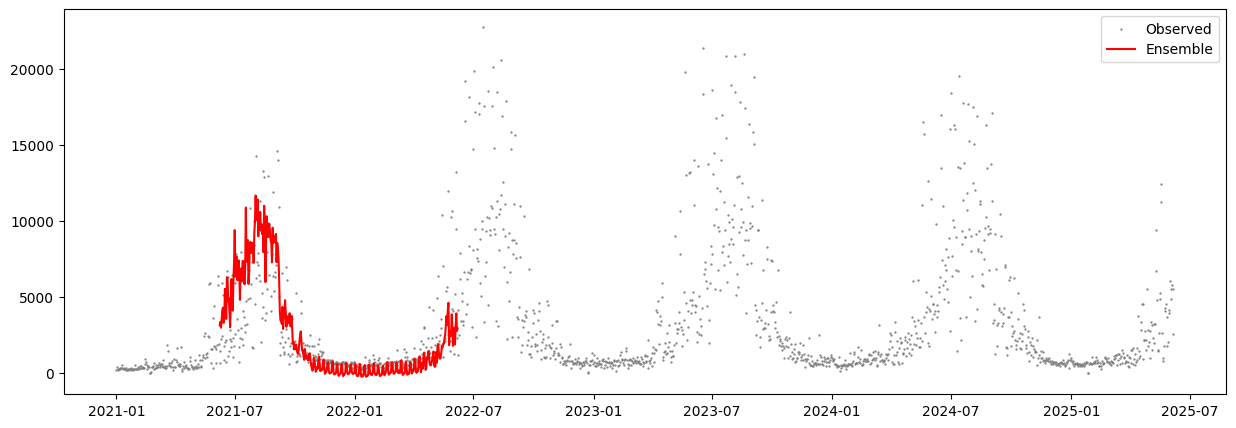

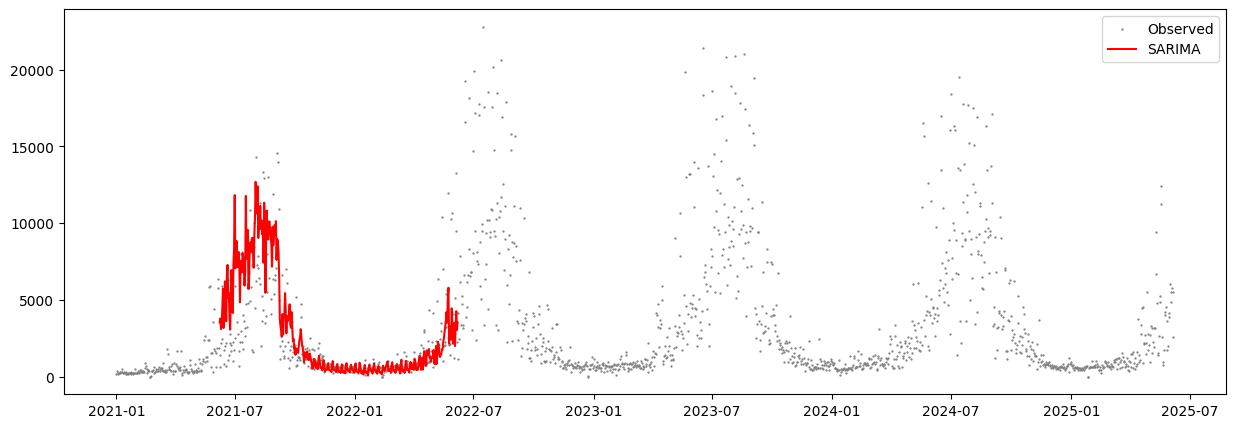

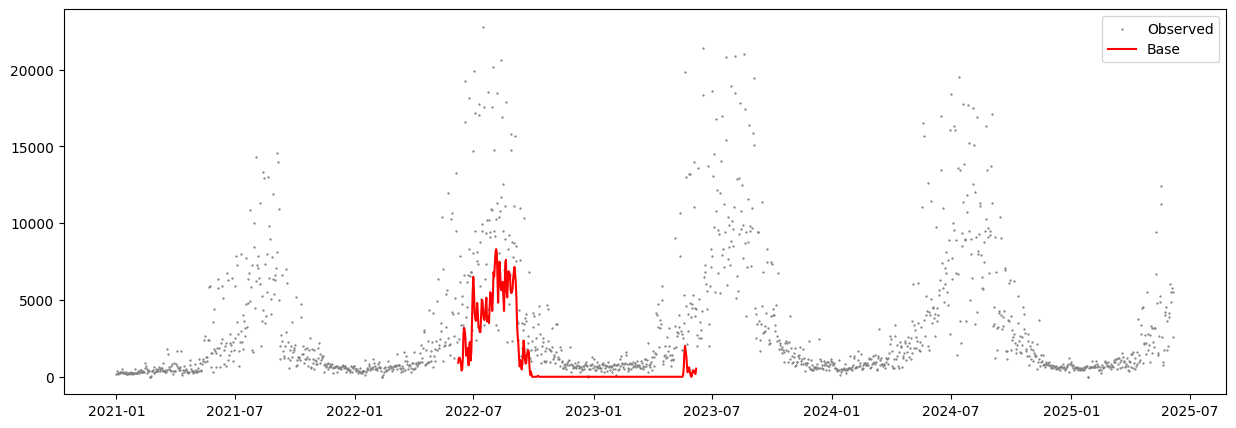

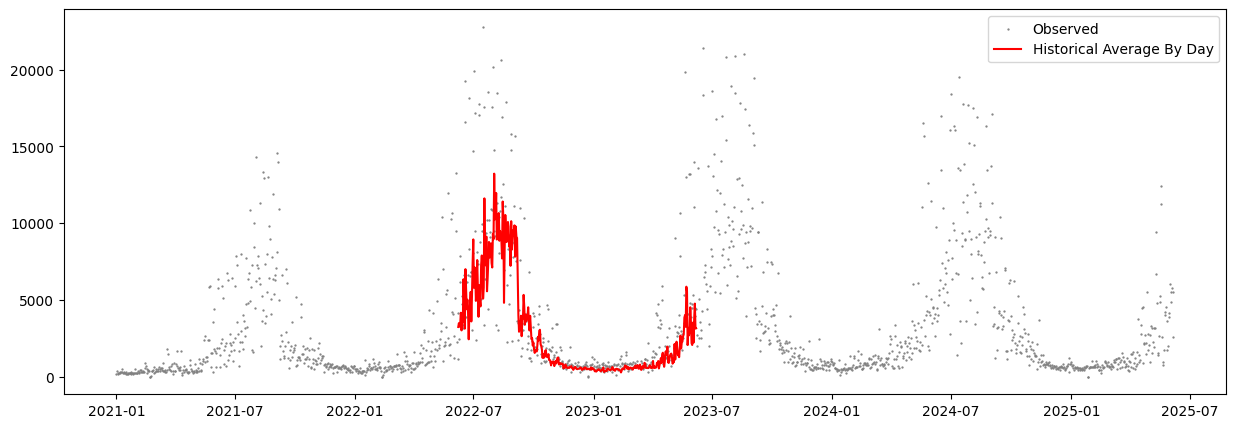

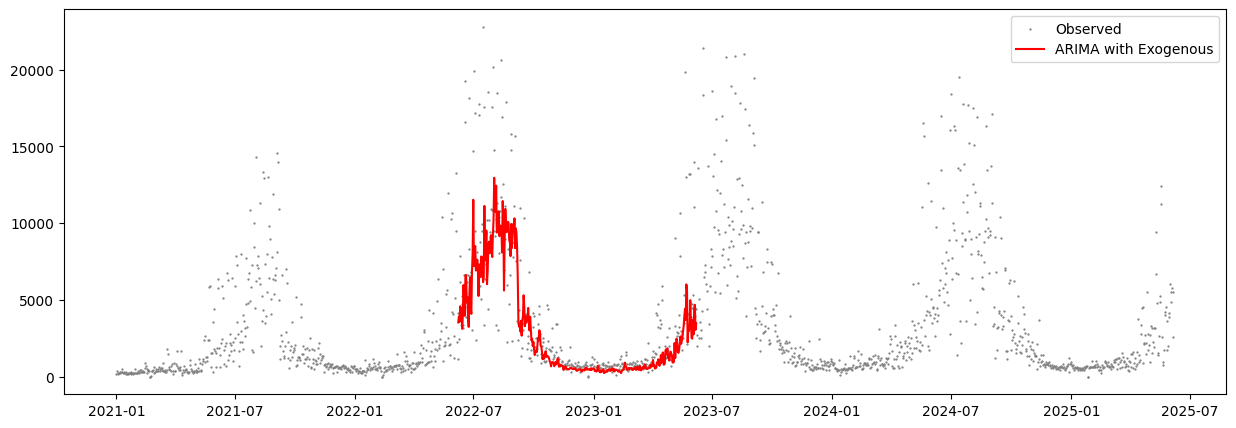

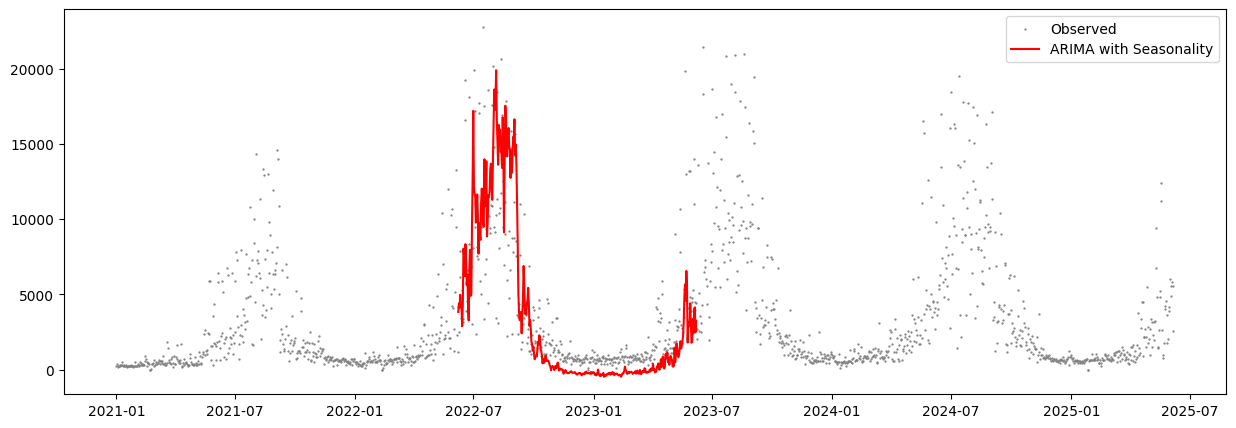

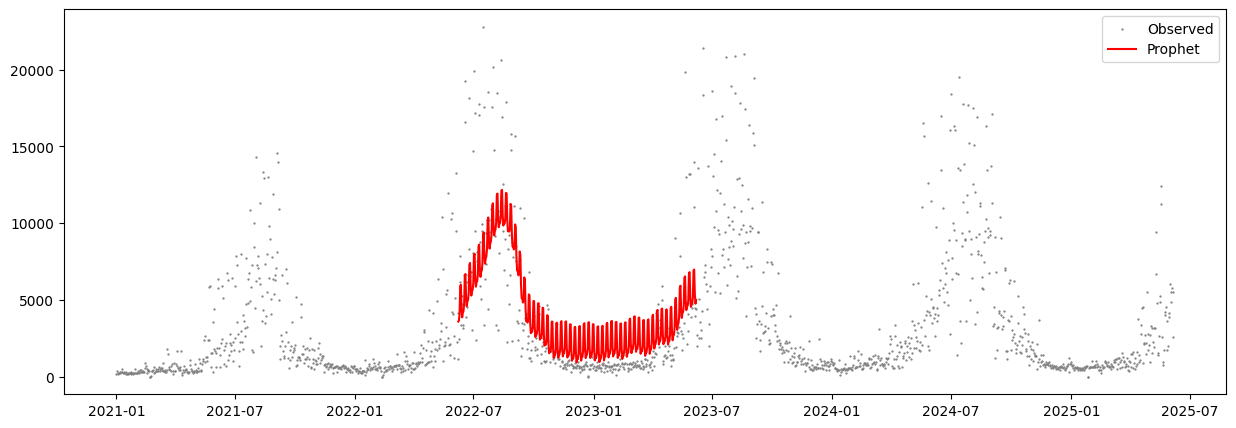

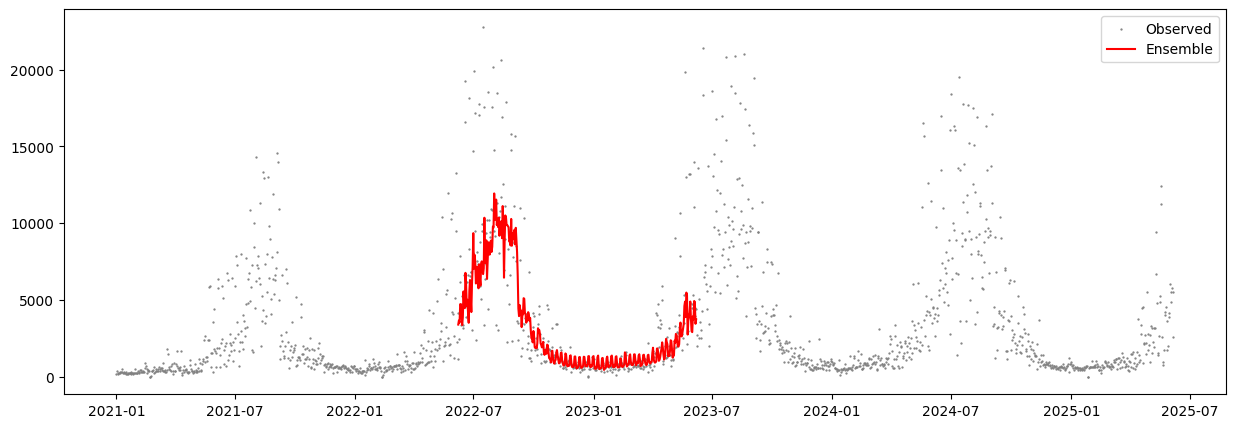

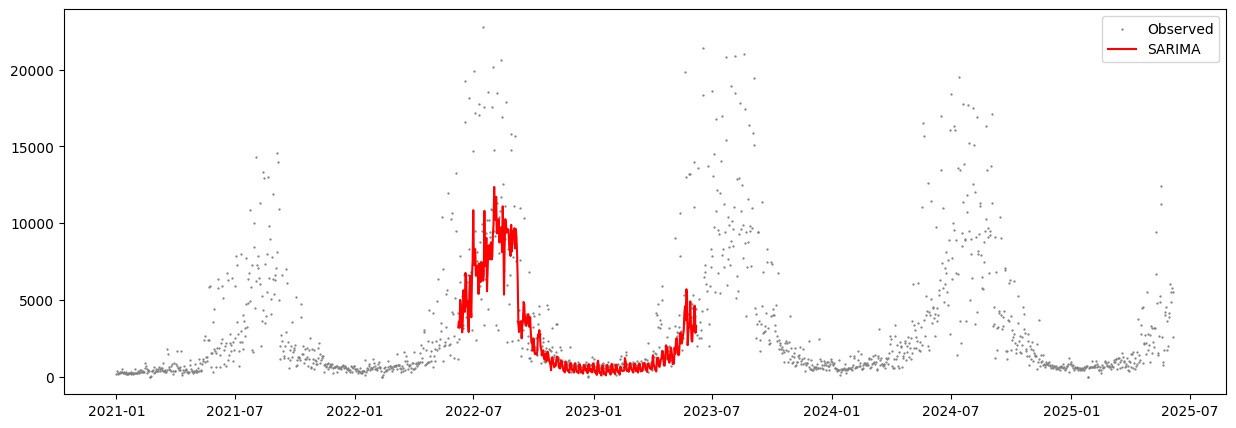

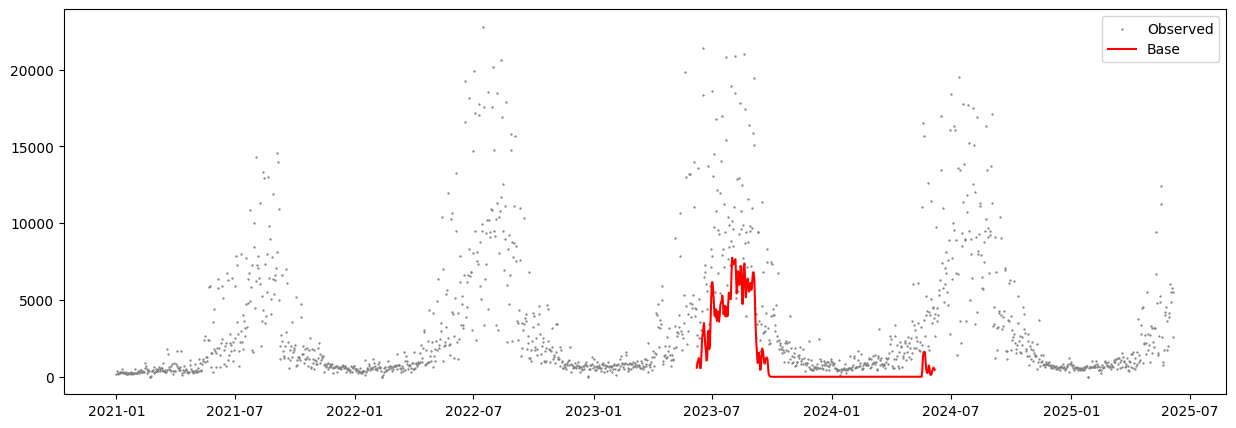

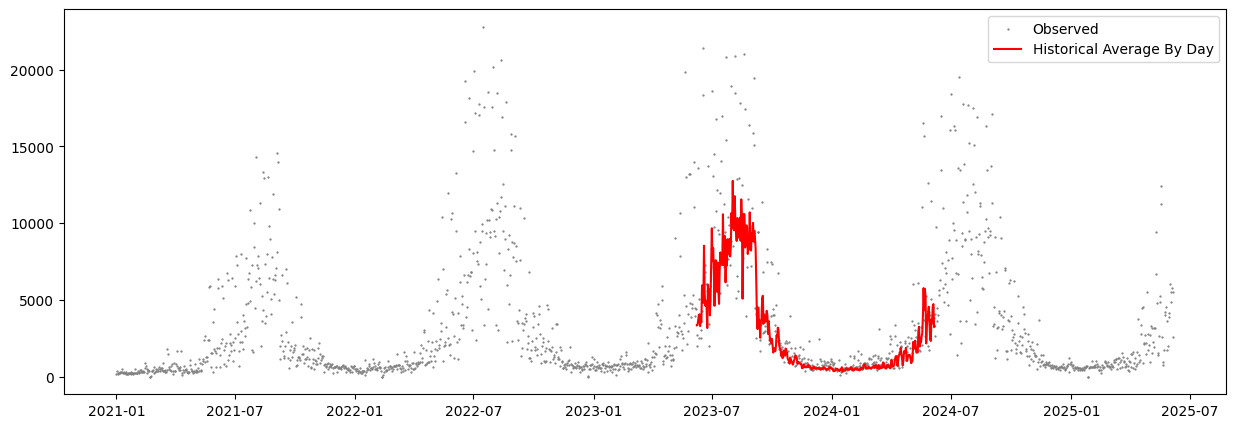

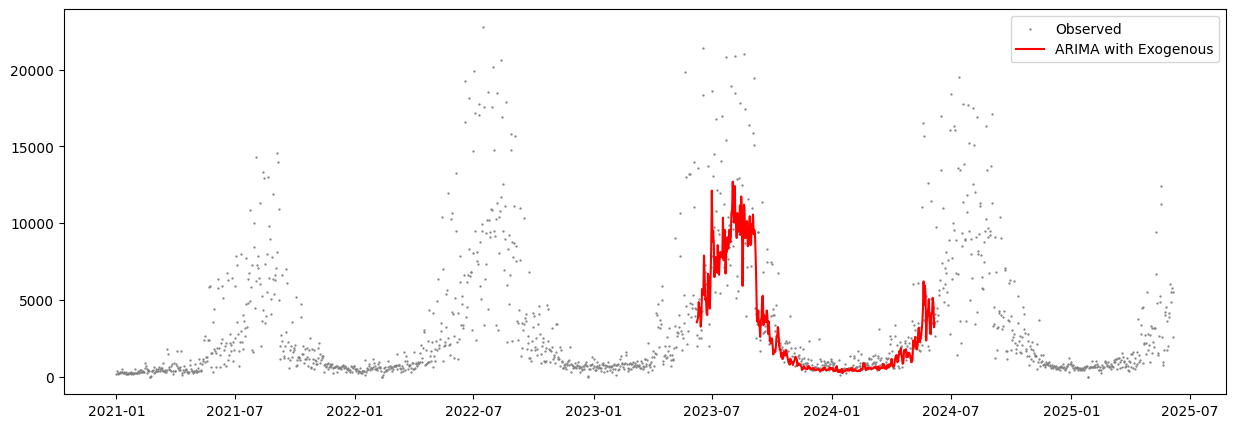

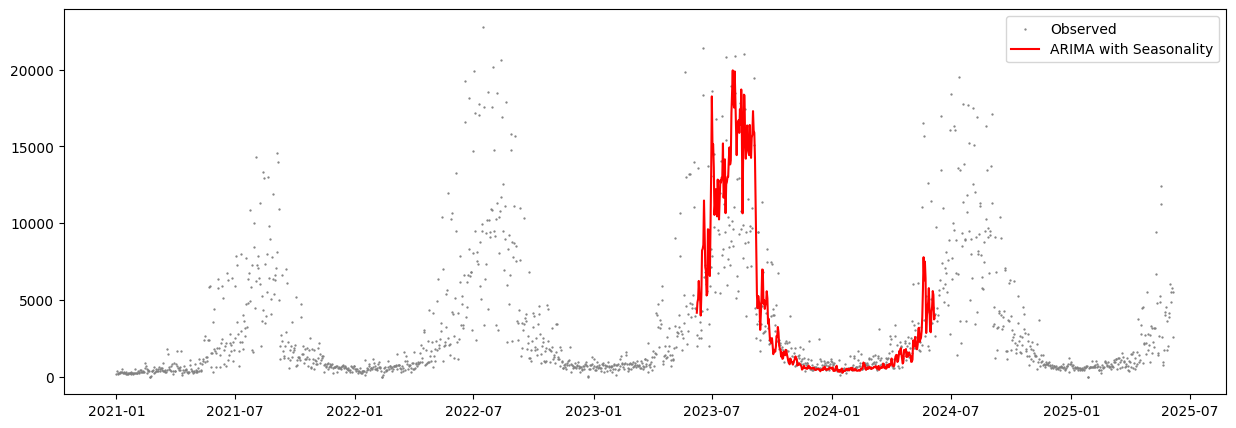

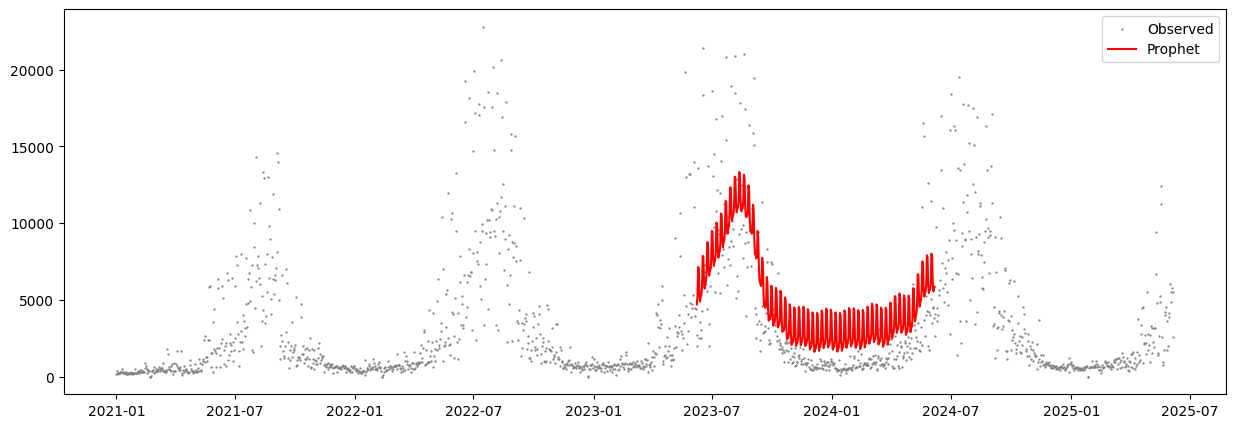

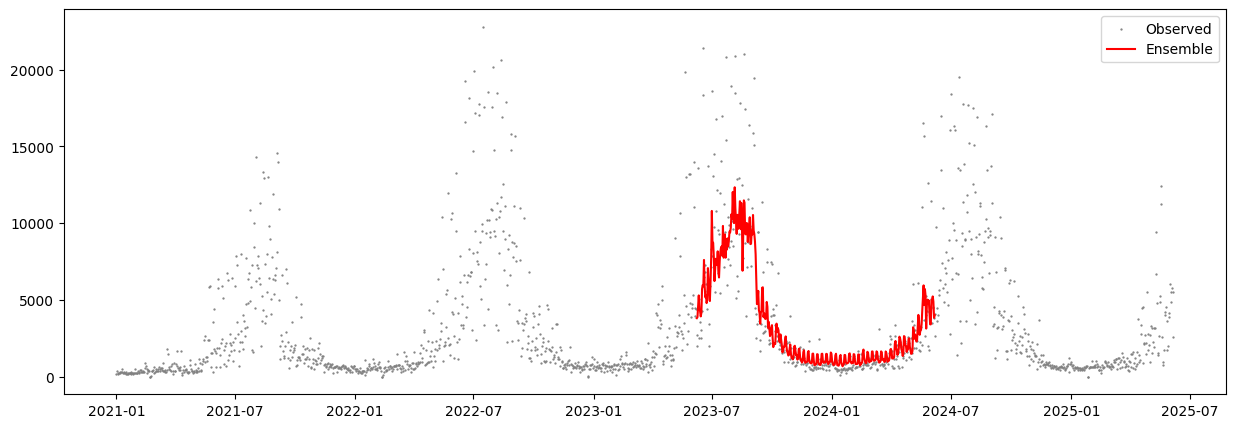

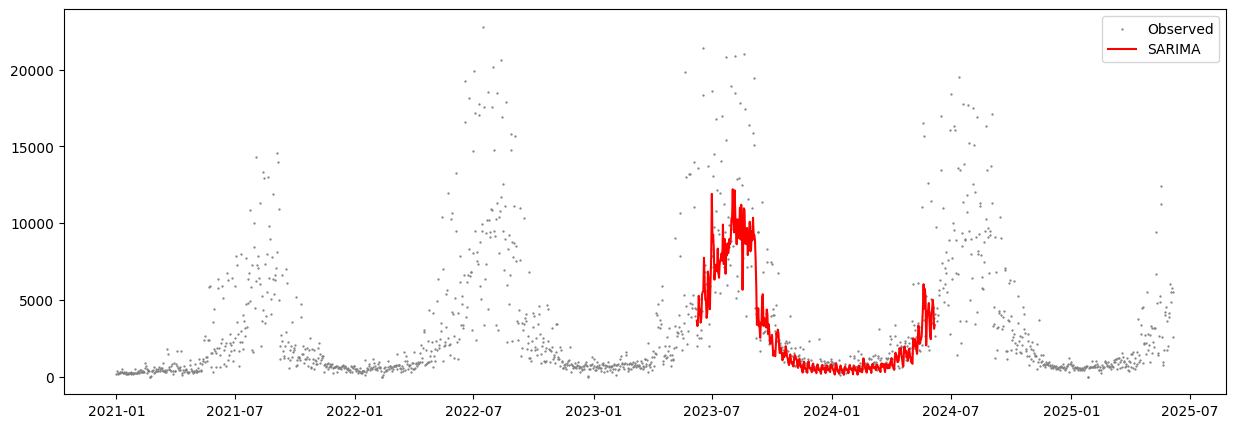

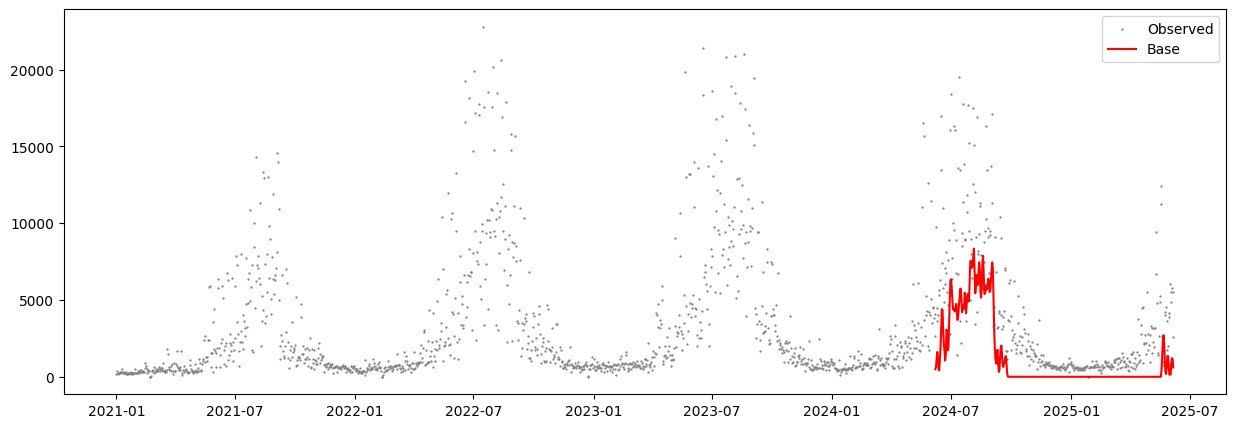

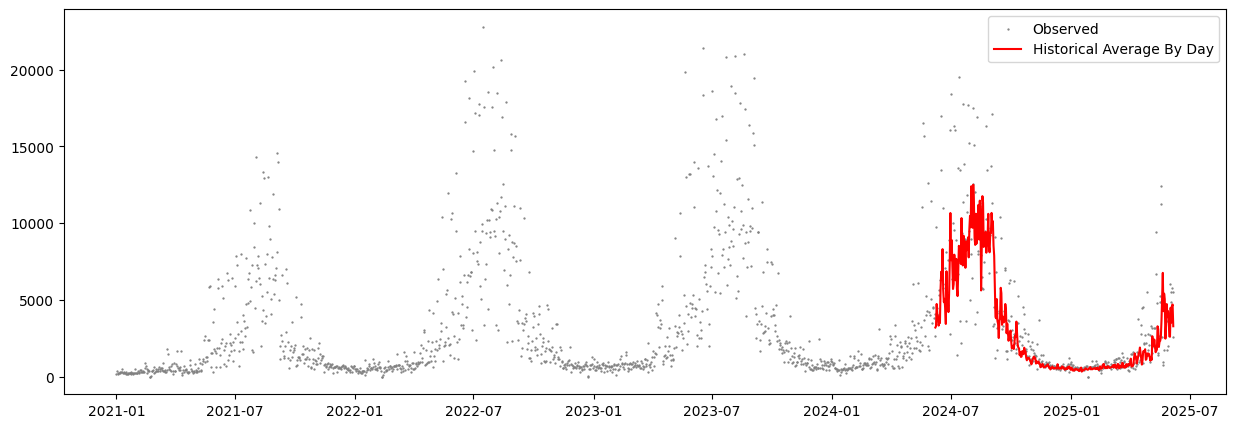

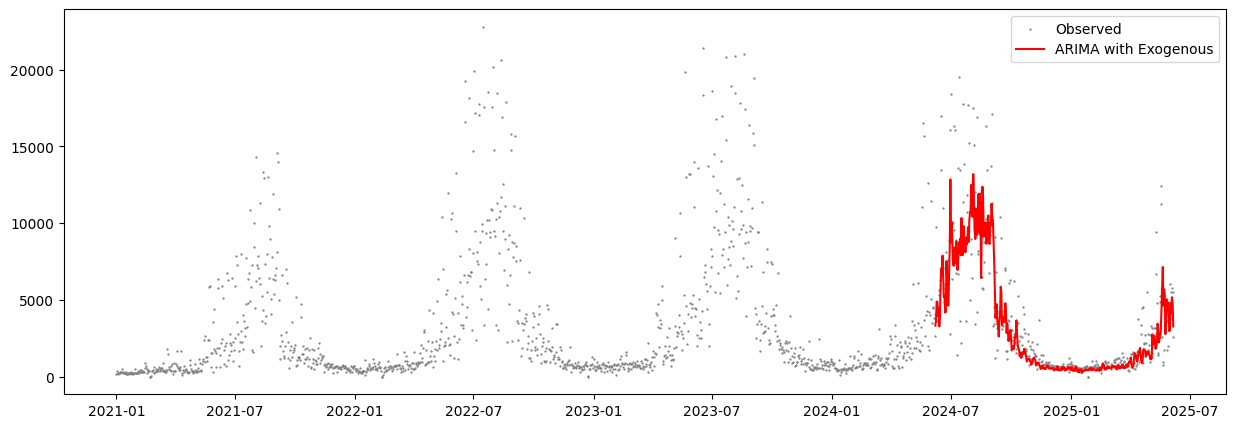

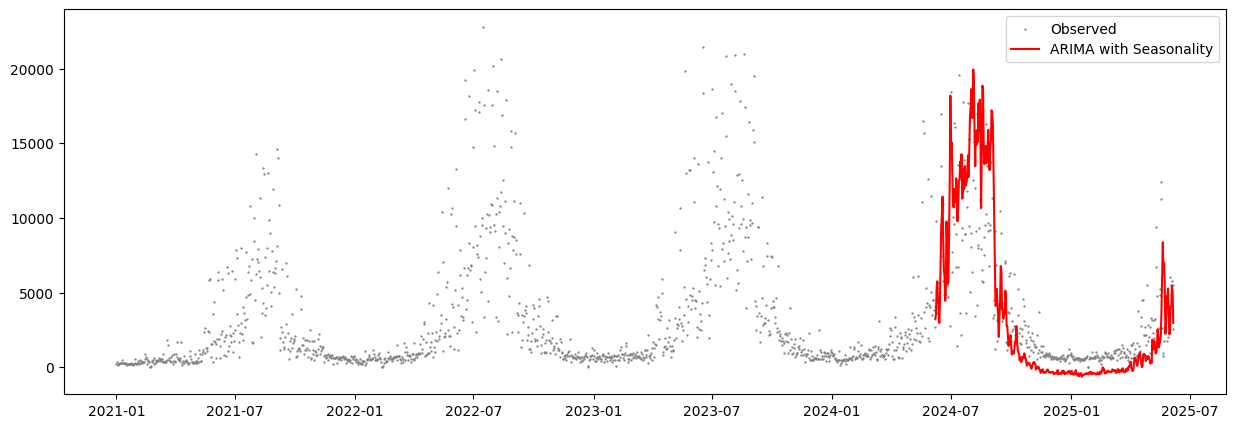

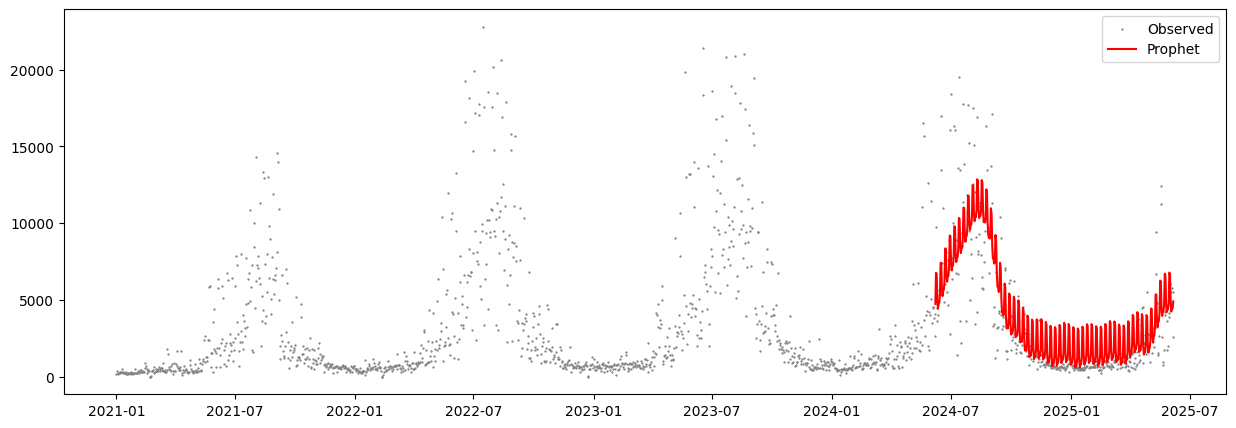

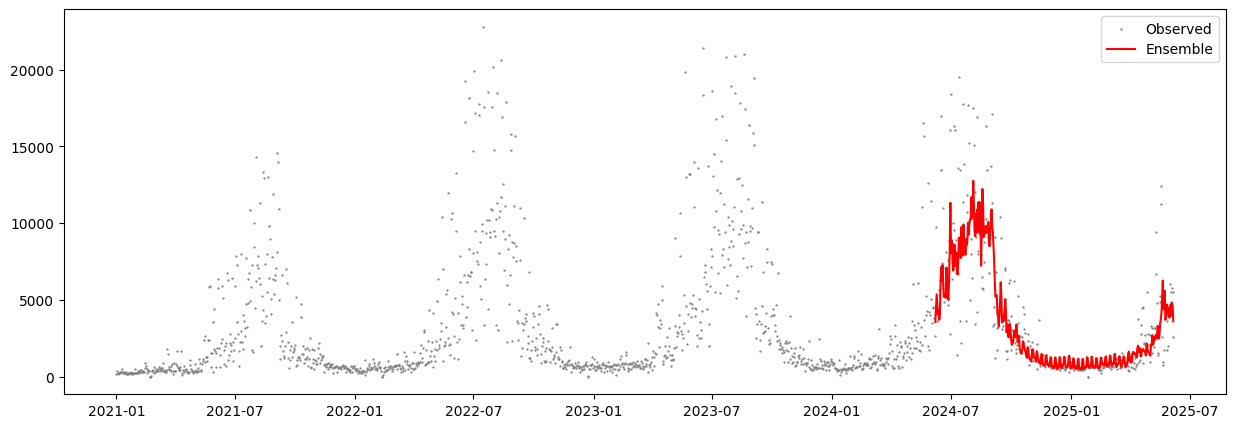

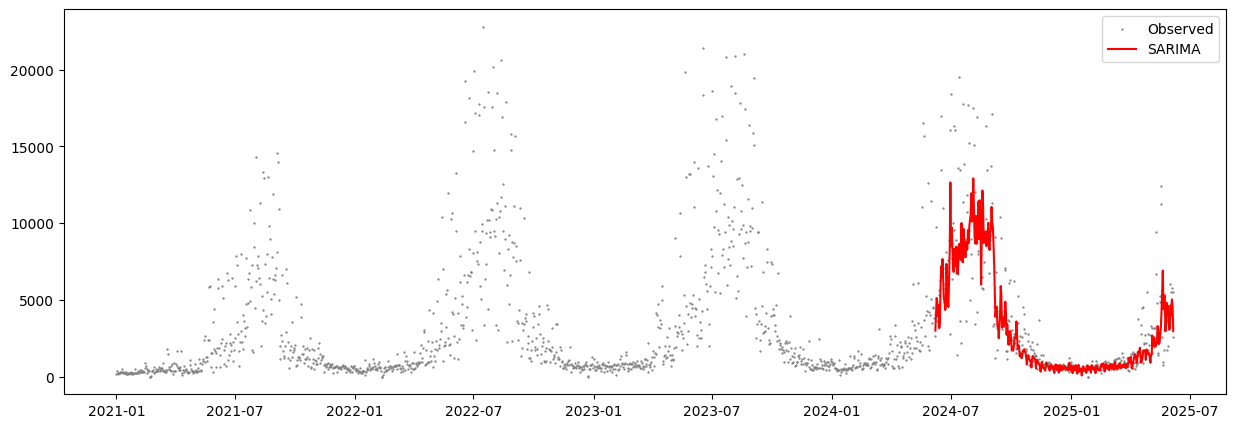

In [4]:
rm = RedemptionModel(df, 
                     target_col='Redemption Count', 
                     exog_cols=['Sales Count']
                     )
rm.run_models()

In [5]:
def average_performance(results):
    for model, splits in results.items():
        metrics = list(next(iter(splits.values())).keys())
        avg_metrics = {metric: 0 for metric in metrics}
        for split in splits.values():
            for metric in metrics:
                avg_metrics[metric] += split[metric]
        for metric in metrics:
            avg_metrics[metric] /= len(splits)
        print(f"Model '{model}':")
        for metric, avg in avg_metrics.items():
            print(f"  {metric:4}: {avg:16,.4f}")
        print()

average_performance(rm.results)

Model 'Base':
  MAPE:           0.8652
  MAE :       2,468.6425
  MSE :  14,659,607.3346

Model 'Historical Average By Day':
  MAPE:           0.4769
  MAE :       1,595.0051
  MSE :   8,527,854.7015

Model 'ARIMA with Exogenous':
  MAPE:           0.4959
  MAE :       1,565.6694
  MSE :   7,953,856.6289

Model 'ARIMA with Seasonality':
  MAPE:           0.8956
  MAE :       2,289.2220
  MSE :  13,827,919.4482

Model 'Prophet':
  MAPE:           1.4159
  MAE :       1,946.4515
  MSE :   7,174,832.7394

Model 'Ensemble':
  MAPE:           0.5935
  MAE :       1,497.8158
  MSE :   7,046,118.3378

Model 'SARIMA':
  MAPE:           0.5154
  MAE :       1,548.4101
  MSE :   7,700,770.9560

